In [22]:
import pennylane as qml
from pennylane import numpy as np
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info.analysis import average_data

In [23]:
dev1 = qml.device('default.qubit',wires=2,analytic=False,shots=1000)

@qml.qnode(dev1)
def circuit(params):
    qml.RY(params[0],wires=0)
    qml.CNOT(wires=[0,1])
    return qml.expval(qml.Hermitian(H,wires=[0,1]))

In [24]:
y = np.array([1/np.sqrt(2),0,0,1/np.sqrt(2)])
H = np.outer(y,y)
print(circuit([np.pi/2]))
dev1.state

0.9999999999999999


array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])

In [35]:
def cross_entropy(predictions, targets, epsilon=1e-20):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log10(predictions+epsilon))/N
    return ce

In [37]:
la = np.array([0.5,0,0,0.5])
def cost(var):
#    return cross_entropy(circuit(var),la) if i'm going to use probs value form qnode
    return abs(1 - circuit(var))

In [38]:
np.random.seed(6)
init_params = np.random.rand(1)
print(init_params)
print(cost(init_params))

[0.89286015]
0.10100000000000009


In [ ]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

# set the number of steps
steps = 1000
# set the initial parameter values
params = init_params
los = np.inf

cost1000 = []
for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)
    t = cost(params)
    cost1000.append(t)

    if (i + 1) % 1 == 0:
        print("Cost after step {:5d}: {: .30f}".format(i + 1, t))

print("Optimized rotation angles: {}".format(params))

In [ ]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

# set the number of steps
steps = 1000
# set the initial parameter values
params = init_params
dev1.shots = 100

cost100 = []
for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)
    t = cost(params)
    cost100.append(t)

    if (i + 1) % 1 == 0:
        print("Cost after step {:5d}: {: .30f}".format(i + 1, t))

print("Optimized rotation angles: {}".format(params))

In [ ]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

# set the number of steps
steps = 1000
# set the initial parameter values
params = init_params
dev1.shots = 10

cost10 = []
for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)
    t = cost(params)
    cost10.append(t)

    if (i + 1) % 1 == 0:
        print("Cost after step {:5d}: {: .30f}".format(i + 1, t))

print("Optimized rotation angles: {}".format(params))

In [ ]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

# set the number of steps
steps = 1000
# set the initial parameter values
params = init_params
dev1.shots = 1

cost1 = []
for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)
    t = cost(params)
    cost1.append(t)

    if (i + 1) % 1 == 0:
        print("Cost after step {:5d}: {: .30f}".format(i + 1, t))

print("Optimized rotation angles: {}".format(params))

In [ ]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

# set the number of steps
steps = 1000
# set the initial parameter values
params = init_params
dev1.analytic = True

cost_analytic = []
for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)
    t = cost(params)
    cost_analytic.append(t)

    if (i + 1) % 1 == 0:
        print("Cost after step {:5d}: {: .30f}".format(i + 1, t))

print("Optimized rotation angles: {}".format(params))

In [26]:
from matplotlib import pyplot as plt
plt.style.use("fast")

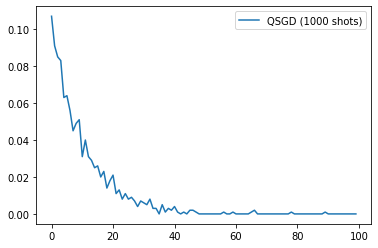

In [27]:
plt.plot(cost1000[:100] ,label="QSGD (1000 shots)")
plt.legend()

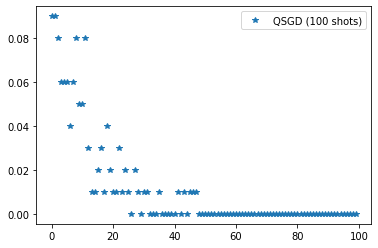

In [28]:
plt.plot(cost100[:100], "*", label="QSGD (100 shots)")
plt.legend()

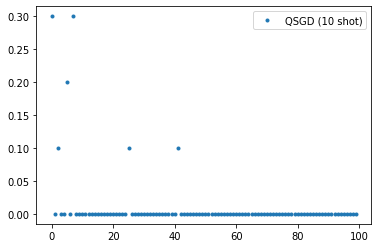

In [29]:
plt.plot(cost10[:100],".", label="QSGD (10 shot)")
plt.legend()

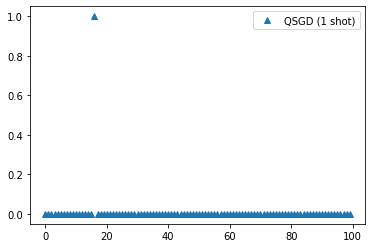

In [30]:
plt.plot(cost1[:100],"^", label="QSGD (1 shot)")
plt.legend()

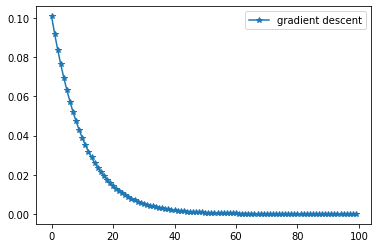

In [31]:
plt.plot(cost_analytic[:100],"-*", label="gradient descent")
plt.legend()

In [32]:
print(np.argmin(cost1000),np.argmin(cost100),np.argmin(cost10),np.argmin(cost1),np.argmin(cost_analytic))

35 26 1 0 336


In [33]:
abs(np.dot(dev1.state.conj().T,y))**2

0.9999999999999998

In [34]:
dev1.state

array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])